# Resources

- https://www.cs.ubc.ca/~schmidtm/Courses/340-F15/L31.pdf
- https://en.wikipedia.org/wiki/Spectral_clustering
- https://en.wikipedia.org/wiki/Laplacian_matrix
- https://towardsdatascience.com/spectral-clustering-for-beginners-d08b7d25b4d8
- http://blog.shriphani.com/2015/04/06/the-smallest-eigenvalues-of-a-graph-laplacian/

# Import 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.stats import norm, multivariate_normal
from SimPEG.utils import mkvc
from sklearn import datasets
from sklearn.cluster import KMeans
import scipy.sparse as sp

In [2]:
# example dataset
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)

Text(0.5, 1.0, 'TRUE CLASSIFICATION')

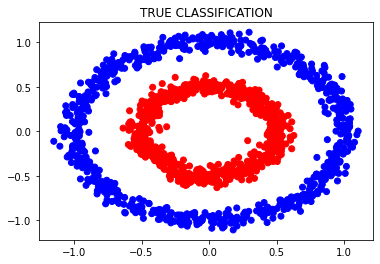

In [3]:
plt.scatter(noisy_circles[0][:,0],noisy_circles[0][:,1],c=noisy_circles[1],cmap='bwr')
plt.gca().set_title('TRUE CLASSIFICATION')

# Build the Matrices

## Adjacency Matrix

In [4]:
data_subset_for_test = noisy_circles[0]

In [5]:
tree = KDTree(data_subset_for_test)

In [6]:
# find k-neighbors of each point
kneighbors = 10
knearest, kindx = tree.query(data_subset_for_test,k=kneighbors+1)
kindx = kindx[:,1:]

In [7]:
kindx

array([[  15,  337,   74, ...,  200,  538, 1476],
       [ 953,  685, 1431, ...,  302,  895,  980],
       [ 831,  776,  582, ...,  451,  639,  714],
       ...,
       [1125,  675,  286, ..., 1491,  482,  433],
       [1111,  439,  406, ..., 1150,  381,  470],
       [ 412,  516, 1152, ..., 1488,  757,  618]])

In [8]:
# build sparse adjacency matrix
A = sp.lil_matrix((data_subset_for_test.shape[0],data_subset_for_test.shape[0]))
A[:,kindx] = 1.
plt.spy(A,markersize=0.1)

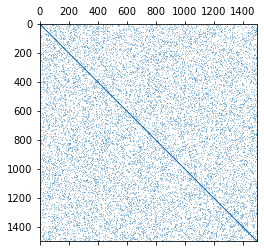

In [128]:
# build sparse Laplacian matrix
L = sp.diags(kneighbors * np.ones(data_subset_for_test.shape[0])) - A
plt.spy(L,markersize=0.1)

In [10]:
# find the 2 biggest eigenvectors of the adjacency matrix
keig = 2
eigenvalues,eigenvectors = sp.linalg.eigs(A,k=keig)
eigenvalues,eigenvectors = eigenvalues.real,eigenvectors.real

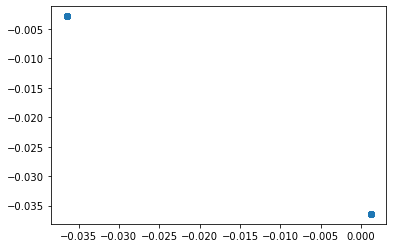

In [124]:
plt.scatter(eigenvectors[:,0],eigenvectors[:,1])

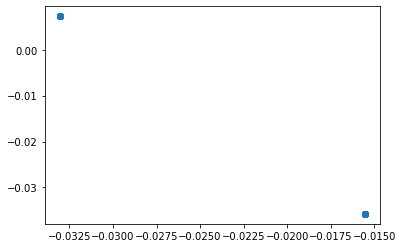

In [134]:
# find the 2 smallest eigenvectors of the adjacency matrix
keig = 2
eigenvalues,eigenvectors = sp.linalg.eigs(L,k=keig,which='SM')
eigenvalues,eigenvectors = eigenvalues.real,eigenvectors.real

plt.scatter(eigenvectors[:,0],eigenvectors[:,1])

In [135]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(eigenvectors)

Text(0.5, 1.0, 'SPECTRAL CLUSTERING CLASSIFICATION PREDICTION')

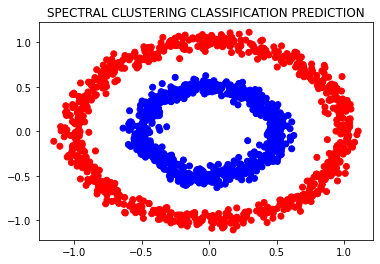

In [136]:
plt.scatter(noisy_circles[0][:,0],noisy_circles[0][:,1],c=kmeans.labels_,cmap='bwr')
plt.gca().set_title('SPECTRAL CLUSTERING CLASSIFICATION PREDICTION')

# Summarize in function

In [36]:
def spectral_clustering_adjacency(data,kneighbors,keigenvalues,n_clusters,tree_opts={}):
    
    tree = KDTree(data)
    
    # find kn-neighbors of each point
    print('Building the KDTree')
    knearest, kindx = tree.query(data,k=kneighbors+1,**tree_opts)
    kindx = kindx[:,1:]
    
    # build sparse adjacency matrix
    print('Building the Adjacency matrix')
    A = sp.lil_matrix((data.shape[0],data.shape[0]))
    A[:,kindx] = 1.
    
    # find the ke-biggest eigenvectors of the adjacency matrix
    print('Computing the eigenvectors')
    eigenvalues,eigenvectors = sp.linalg.eigs(A,k=keigenvalues, which='LR')
    eigenvalues,eigenvectors = eigenvalues.real,eigenvectors.real
    
    #
    print('Running KMeans')
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(eigenvectors)
    
    return kmeans, eigenvectors

In [37]:
# Laplacian approach might be easier for eigenvalue thanks to the dominating diagonal
def spectral_clustering_laplacian(data,kneighbors,keigenvalues,n_clusters,tree_opts={}):
    
    tree = KDTree(data)
    
    # find kn-neighbors of each point
    print('Building the KDTree')
    knearest, kindx = tree.query(data,k=kneighbors+1,**tree_opts)
    kindx = kindx[:,1:]
    
    # build sparse adjacency matrix
    print('Building the Adjacency matrix')
    A = sp.lil_matrix((data.shape[0],data.shape[0]))
    A[:,kindx] = 1.
    
    L = sp.diags(kneighbors * np.ones(data.shape[0])) - A
    
    # find the ke-biggest eigenvectors of the adjacency matrix
    print('Computing the eigenvectors')
    eigenvalues,eigenvectors = sp.linalg.eigs(L,k=keigenvalues, which='SR')
    eigenvalues,eigenvectors = eigenvalues.real,eigenvectors.real
    
    #
    print('Running KMeans')
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(eigenvectors)
    
    return kmeans, eigenvectors

### test

Building the KDTree
Building the Adjacency matrix
Computing the eigenvectors
Running KMeans


Text(0.5, 1.0, 'SPECTRAL CLUSTERING CLASSIFICATION PREDICTION: ADJACENT')

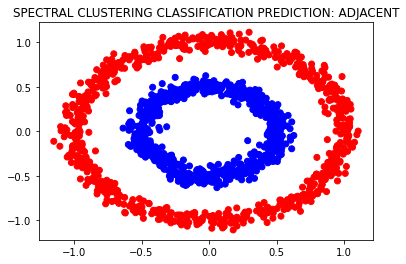

In [38]:
spectral_cir, _ = spectral_clustering_adjacency(
    noisy_circles[0],
    kneighbors=10,
    keigenvalues=2,
    n_clusters=2,
    tree_opts={'p':1}
)
plt.scatter(noisy_circles[0][:,0],noisy_circles[0][:,1],c=spectral_cir.labels_,cmap='bwr')
plt.gca().set_title('SPECTRAL CLUSTERING CLASSIFICATION PREDICTION: ADJACENT')

Building the KDTree
Building the Adjacency matrix
Computing the eigenvectors
Running KMeans


Text(0.5, 1.0, 'SPECTRAL CLUSTERING CLASSIFICATION PREDICTION: LAPLACIAN')

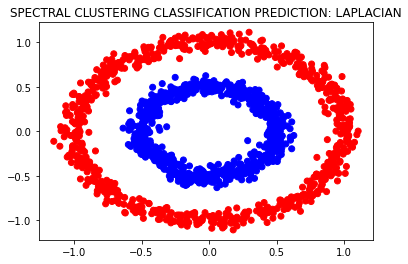

In [39]:
spectral_cir, _ = spectral_clustering_laplacian(
    noisy_circles[0],
    kneighbors=10,
    keigenvalues=2,
    n_clusters=2,
    tree_opts={'p':1}
)
plt.scatter(noisy_circles[0][:,0],noisy_circles[0][:,1],c=spectral_cir.labels_,cmap='bwr')
plt.gca().set_title('SPECTRAL CLUSTERING CLASSIFICATION PREDICTION: LAPLACIAN')

# Spectral clustering for Image Segmentation

In [40]:
from skimage import data as data_import
from skimage.transform import  rescale
from scipy.stats import boxcox, yeojohnson

In [41]:
astronaut = data_import.astronaut()
# downsample for speed of tutorial
astronaut = rescale(astronaut, 1.0 / 4.0, anti_aliasing=True,multichannel=True,mode='reflect')

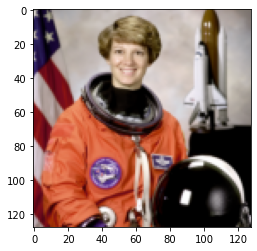

In [42]:
plt.imshow(astronaut)

In [43]:
# built the data to train the tree

# including the coords for continuous classification is a bad idea
#x = np.linspace(0,1.,astronaut.shape[0])
#y = np.linspace(0,1.,astronaut.shape[1])
#X,Y = np.meshgrid(x,y)

#normalize the data
rgb = astronaut.reshape(-1,3)/255.
r = yeojohnson(rgb[:,0])[0]
g = yeojohnson(rgb[:,1])[0]
b = yeojohnson(rgb[:,2])[0]

image_data = np.c_[
    #yeojohnson(X.flatten())[0].reshape(-1,1),
    #yeojohnson(Y.flatten())[0].reshape(-1,1),
    r,g,b
]

In [52]:
spectral_ast, eigv_ast = spectral_clustering_laplacian(
    rgb,
    kneighbors=128,
    keigenvalues=3, # dimensionality reduction
    n_clusters=3,
    tree_opts={'p':2}
)

Building the KDTree
Building the Adjacency matrix
Computing the eigenvectors
Running KMeans


Text(0.5, 0.98, 'Original space and spectral clustering result')

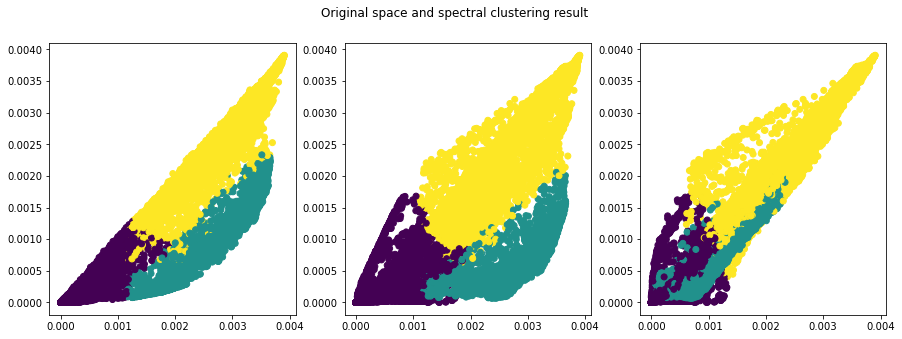

In [61]:
# compare original space, yeojohnson space, and eigenvector space
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(rgb[:,0],rgb[:,1],c=spectral_ast.labels_)
ax[1].scatter(rgb[:,0],rgb[:,2],c=spectral_ast.labels_)
ax[2].scatter(rgb[:,1],rgb[:,2],c=spectral_ast.labels_)
fig.suptitle('Original space and spectral clustering result')

Text(0.5, 0.98, 'Yeojohnson space and spectral clustering result')

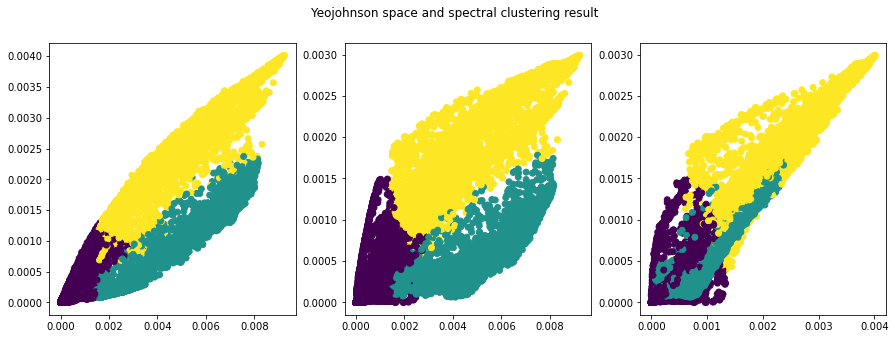

In [62]:
# compare original space, yeojohnson space, and eigenvector space
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(r,g,c=spectral_ast.labels_)
ax[1].scatter(r,b,c=spectral_ast.labels_)
ax[2].scatter(g,b,c=spectral_ast.labels_)
fig.suptitle('Yeojohnson space and spectral clustering result')

Text(0.5, 0.98, 'Eigenvector space and spectral clustering result')

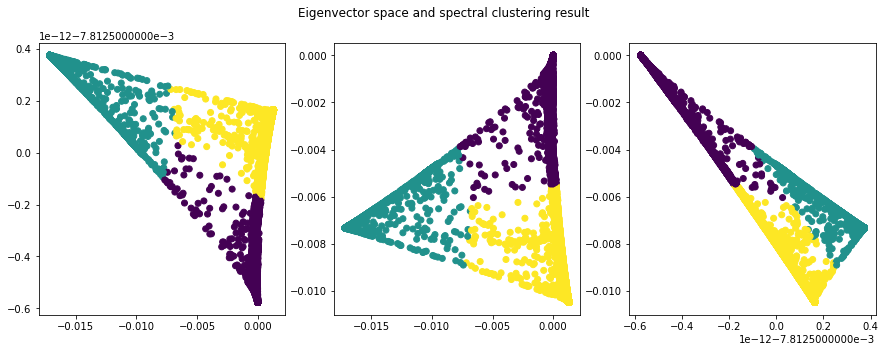

In [63]:
# compare original space, yeojohnson space, and eigenvector space
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(eigv_ast[:,0],eigv_ast[:,1],c=spectral_ast.labels_)
ax[1].scatter(eigv_ast[:,0],eigv_ast[:,2],c=spectral_ast.labels_)
ax[2].scatter(eigv_ast[:,1],eigv_ast[:,2],c=spectral_ast.labels_)
fig.suptitle('Eigenvector space and spectral clustering result')

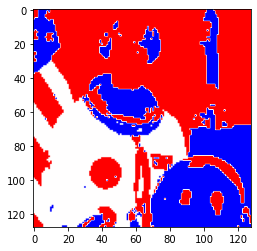

In [64]:
# visualize the location of clusters
plt.imshow(spectral_ast.labels_.reshape(astronaut.shape[:2]),cmap='bwr')

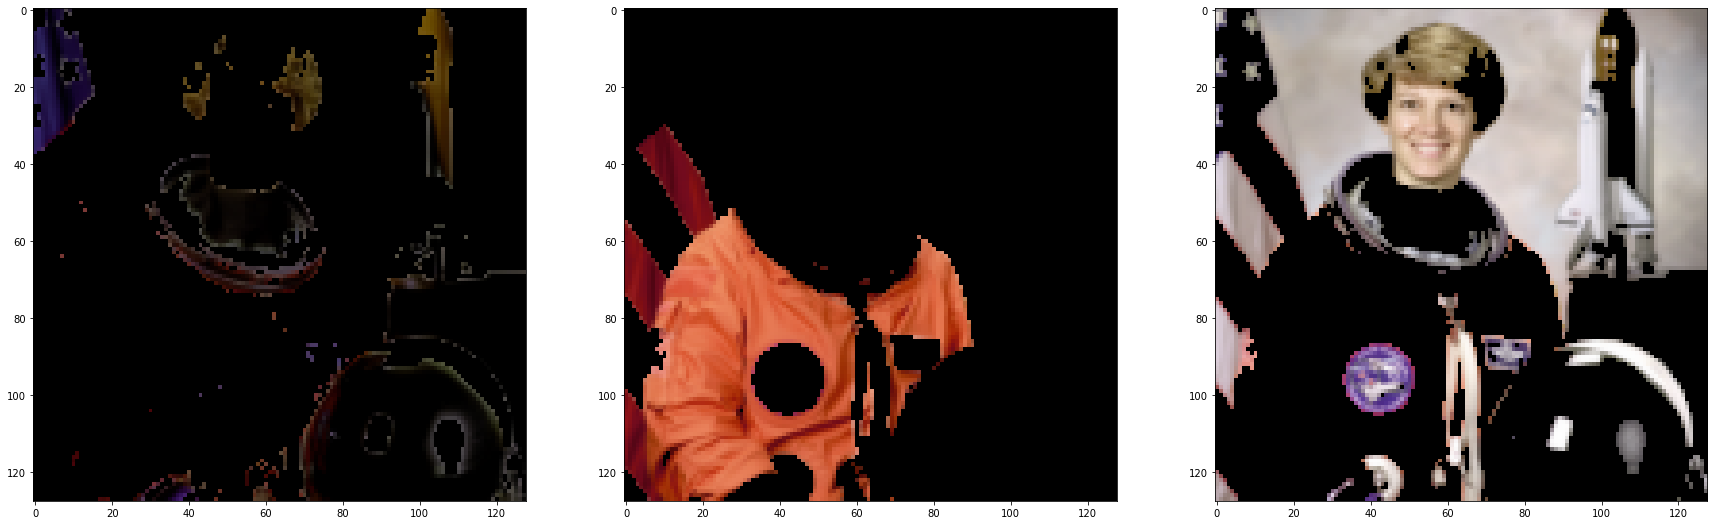

In [65]:
# visualize the resulting segmented image
fig, ax = plt.subplots(1,3,figsize=(30,10))
ax = ax.flatten()
clusters_label = np.unique(spectral_ast.labels_)
for i, cls in enumerate(clusters_label):
    cluster = np.zeros_like(astronaut)
    indx = spectral_ast.labels_.reshape(astronaut.shape[:2]) == cls
    cluster[indx] = astronaut[indx]
    
    ax[i].imshow(cluster)